In [1]:
# import relevant module for this task
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# Overview
With this data set, we want to build an algorithm to see whether or not a consumer willrepay their debt to a lender.

# Variable Description

In [2]:
# extend column with so as to fully diplay description of each variable
pd.set_option('max_colwidth', 200)

# read variable description
data_dictionary = pd.read_excel('../data/Data Dictionary.xls')

# store variable name for later use
y_label = data_dictionary['Variable Name'][0]
X_label = data_dictionary['Variable Name'][1:].values
all_label = data_dictionary['Variable Name'].values

# show the variable and its description
display(data_dictionary)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


# Check out data 

In [3]:
pd.set_option('max_colwidth', 100)
cs_training = pd.read_csv('../data/cs-training.csv', index_col=0)
cs_training.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


# Pearson correlation between predicted and predicting variables

In [4]:
cs_training.corr()[['SeriousDlqin2yrs']]

,SeriousDlqin2yrs
SeriousDlqin2yrs,1.000000
RevolvingUtilizationOfUnsecuredLines,-0.001802
age,-0.115386
NumberOfTime30-59DaysPastDueNotWorse,0.125587
DebtRatio,-0.007602
MonthlyIncome,-0.019746
NumberOfOpenCreditLinesAndLoans,-0.029669
NumberOfTimes90DaysLate,0.117175
NumberRealEstateLoansOrLines,-0.007038
NumberOfTime60-89DaysPastDueNotWorse,0.102261


# Descriptive Statistics

In [5]:
pd.set_option('max_colwidth', 100)
cs_training = pd.read_csv('../data/cs-training.csv', index_col=0)
cs_training.describe(percentiles=[.5, .9, .95, .99])

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
90%,0.000000,0.981278,72.000000,1.000000,1267.000000,1.166600e+04,15.000000,0.000000,2.000000,0.000000,2.000000
95%,1.000000,1.000000,78.000000,2.000000,2449.000000,1.458760e+04,18.000000,1.000000,3.000000,1.000000,3.000000
99%,1.000000,1.092956,87.000000,4.000000,4979.040000,2.500000e+04,24.000000,3.000000,4.000000,2.000000,4.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


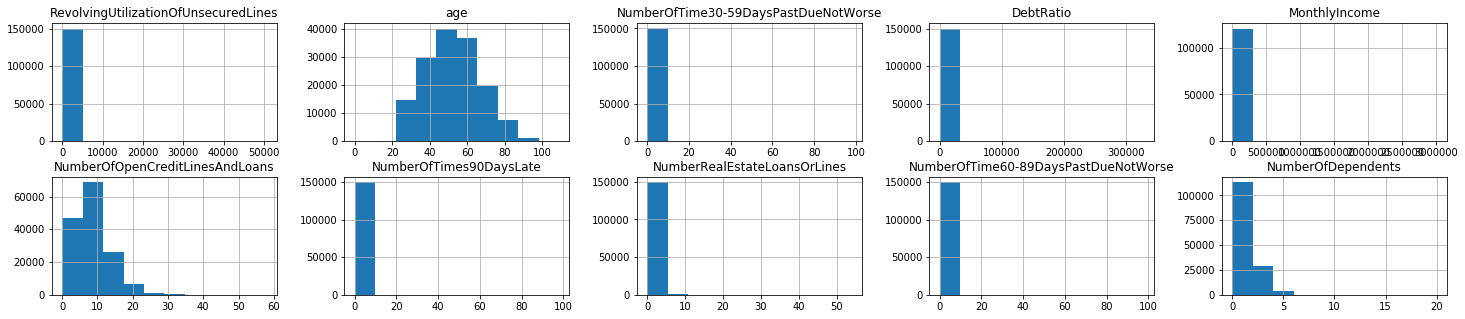

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(25,5))
i = 0
for label in X_label:
    cs_training.loc[:, cs_training.columns==label].hist(figsize=(20,5), ax=ax[int(i/5)][i%5])
    i+=1
plt.show()

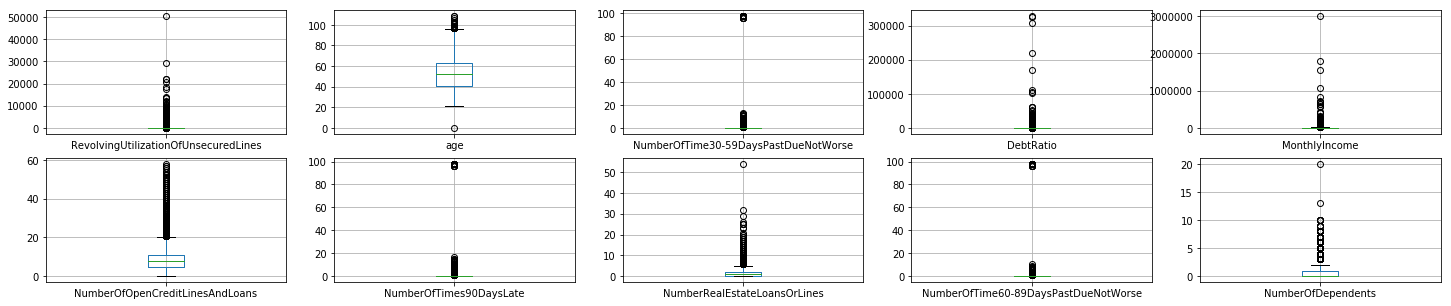

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(25,5))
i = 0
for label in X_label:
    cs_training.loc[:, cs_training.columns==label].boxplot(figsize=(20,5), ax=ax[int(i/5)][i%5])
    i+=1
plt.show()

# Descriptive Statistics:
Data size is 15,000 with 1 predicted variable - SeriousDlqin2yrs- and 10 predicting variables.
## Predicted Variable: SeriousDlqin2yrs
SeriousDlqin2yrs is highly imbalanced since roughly only 6.8% record is assigned to '1'.
## Predicting Variable
### Variable Distribution
Age is close to normal distribution.
NumberOfOpenCreditLinesAndLoans is close to log normal distribution.
The remaining variables seem to have very serious outlier problem.
### Missing Value
Both MonthlyIncome and NumberOfDependents has missing value.

By definition, MonthlyIncome will be used to calculate DebtRatio. 

My conjecture is that record with a null/0 MonthlyIncome wouldn't have valid DebtRatio.

# Simple Solution
## Drop all records with at least one missing value
## Ignore outlier and imbalaned nature of predicted label

In [10]:
# drop all rows with at least one missing value
data = cs_training.dropna()

# 
X = data[X_label]
y = data[y_label]

# split data into training and validing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 0)

# build an Ada Boost Classifier with Decision Tree
ada_boost = Pipeline([('clf', AdaBoostRegressor(random_state=0))])

# fit the model
ada_boost.fit(X_train, y_train)
y_pred = ada_boost.predict(X_test)

# evaluate the model
print('auc score: ', end = '')
print(roc_auc_score(y_test, y_pred))


for i in range(len(y_pred)):
    if y_pred[i] >0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
print(classification_report(y_test, y_pred))

auc score: 0.8075194549124695
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     22383
           1       0.58      0.13      0.22      1671

    accuracy                           0.93     24054
   macro avg       0.76      0.56      0.59     24054
weighted avg       0.91      0.93      0.91     24054



# A bit complicated model
## Use remaining variable to impute missing value
## Use LocalOutlierFactor to exclude outlier
## Use ADASYN to oversampling minor class

# Predict Missing Value

In [11]:
def predicted_missing_value(data, predicted_label, predicting_label):
    data_without_missing_value = data.loc[~np.isnan(data[predicted_label]),:]
    X_train, X_test, y_train, y_test = train_test_split(\
                                                        data_without_missing_value[predicting_label],\
                                                        data_without_missing_value[predicted_label], \
                                                        test_size=0.2,\
                                                        stratify=data_without_missing_value['SeriousDlqin2yrs']
                                                        , random_state = 0
                                                   )
    linear_regression = Pipeline([('clf', LinearRegression())])
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)
    print('r-square: ', end='')
    print(r2_score(y_test, y_pred))
    
    data_copy = data.copy()
    data_copy['predicted'] = linear_regression.predict(data[predicting_label])

    data_copy.loc[(np.isnan(data[predicted_label])), predicted_label] = data_copy['predicted']
    return data_copy, linear_regression

data_na_filled, linear_regression_1 = predicted_missing_value(cs_training, 'MonthlyIncome', \
                            ['RevolvingUtilizationOfUnsecuredLines','age',\
                             'NumberOfTime30-59DaysPastDueNotWorse','NumberOfOpenCreditLinesAndLoans',\
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',\
                             'NumberOfTime60-89DaysPastDueNotWorse']\
                           )


data_na_filled_2, linear_regression_2 = predicted_missing_value(data_na_filled, 'NumberOfDependents', \
                            ['RevolvingUtilizationOfUnsecuredLines','age',\
                             'NumberOfTime30-59DaysPastDueNotWorse','NumberOfOpenCreditLinesAndLoans',\
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',\
                             'NumberOfTime60-89DaysPastDueNotWorse']\
                           )

r-square: 0.02315168416688096
r-square: 0.06680118140243352


# Exclude Outlier

In [12]:
from sklearn.neighbors import LocalOutlierFactor
local_outlier_factor = LocalOutlierFactor(contamination=0.01)
is_outlier = (local_outlier_factor.fit_predict(data_na_filled_2[X_label]) == -1)
data_outlier_excluded = data_na_filled_2.loc[~is_outlier,:]

# Oversampling

In [14]:
X = data_outlier_excluded[X_label]
y = data_outlier_excluded[y_label]

ada = ADASYN()
X_over_sampled, y_over_sampled = ada.fit_resample(X, y)

# Decision Tree with Adaboost

In [15]:
# 
X = X_over_sampled
y = y_over_sampled

# split data into training and validing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 0)

# build an Ada Boost Classifier with Decision Tree
ada_boost = Pipeline([('clf', AdaBoostRegressor(random_state=0))])

# fit the model
ada_boost.fit(X_train, y_train)
y_pred = ada_boost.predict(X_test)

# evaluate the model
print('auc score: ', end = '')
print(roc_auc_score(y_test, y_pred))

for i in range(len(y_pred)):
    if y_pred[i] >0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
print(classification_report(y_test, y_pred))

auc score: 0.9348668531030105
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     27737
           1       0.92      0.82      0.87     27356

    accuracy                           0.88     55093
   macro avg       0.88      0.88      0.88     55093
weighted avg       0.88      0.88      0.88     55093



# Perform Prediction on Test Data

In [16]:
# read test data
cs_test = pd.read_csv('../data/cs-test.csv', index_col=0)

# fill missing value
cs_test['predicted'] = linear_regression_1.predict(cs_test[['RevolvingUtilizationOfUnsecuredLines','age',\
                             'NumberOfTime30-59DaysPastDueNotWorse','NumberOfOpenCreditLinesAndLoans',\
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',\
                             'NumberOfTime60-89DaysPastDueNotWorse']])
cs_test.loc[(np.isnan(cs_test['MonthlyIncome'])), 'MonthlyIncome'] = cs_test['predicted']

cs_test['predicted'] = linear_regression_2.predict(cs_test[['RevolvingUtilizationOfUnsecuredLines','age',\
                             'NumberOfTime30-59DaysPastDueNotWorse','NumberOfOpenCreditLinesAndLoans',\
                             'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',\
                             'NumberOfTime60-89DaysPastDueNotWorse']])
cs_test.loc[(np.isnan(cs_test['NumberOfDependents'])), 'NumberOfDependents'] = cs_test['predicted']

# perform prediction
cs_test = cs_test[all_label]
X = cs_test[X_label]
cs_test['probability'] = ada_boost.predict(X)

# output result
cs_test[['probability']].to_csv('../data/predicted.csv', index_label='id')